# Self-Driving Car Engineer Nanodegree


## Finding Lane Lines on the Road with Hough Transformation
***
In this project, the goal is to detect and draw lane lines for the lane the vehicle is centered in a camera feed.  Before moving to more advanced methods, we will explore what lane line detection can be accomplished with region of interest image masking, Canny edge detection, and Hough line detection. To fine tune this method we employee various filters to the Hough lines, such as removing lines that are nearly flat (horizontal across the image) and other filters. After these filters are applied it's possible to have edges that do not clearly lie along a single long (long being nearly half the image width) line, therefore a linear fit is done to find a line that is compatible with the observations, and that fitted line is used to draw the lane lines. I should be noted that given the geometry of the problem an SVM line may perform better but is not explored here. 

 When we apply this method to sequential images (video) we want to suppress potentially rapid changes to the best fit lines, in order to suppress rapid changes we employee exponential smoothing frame to frame such that the best fit line for an single frame has low influence and any major changes to the best fit lines must persist over multiple frames of the video.
 
  Below we will explore how each of these steps are employed in order to build a simple lane finding pipeline.

## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 #opencv
%matplotlib inline

## Read in a Training Image

This image is:  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


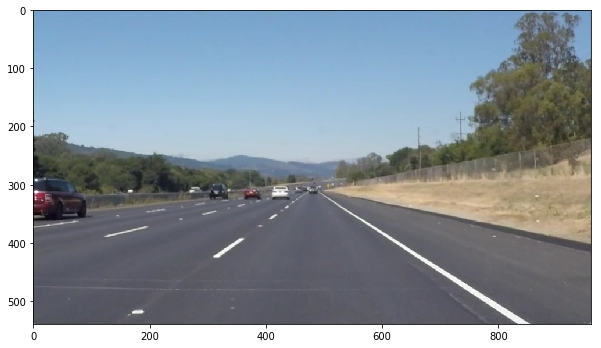

In [2]:
#reading in an image
raw_image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = np.copy(raw_image)
#printing out some stats and visualizing
print('This image is: ', type(raw_image), 'with dimensions: ', raw_image.shape)
plt.figure(figsize=(10,7))
plt.imshow(raw_image);

Our training image above is an idealistic straight roadway with clear white lane indications on a dark background of asphalt road on a clear sunny day with high visibility.  Furthermore the image is on a highway and thus we do not need to worry about sharp turn issues in our pipeline. Let's look at the channel information in this image and see if anything jumps out at us as a relavent feature towards the task.

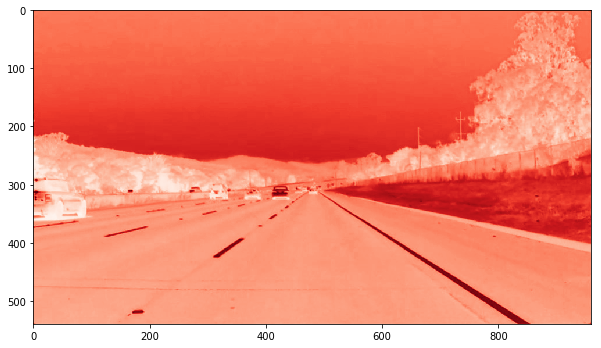

In [3]:
# seperate the channels
plt.figure(figsize=(10,7))
plt.imshow(image[:,:,0],cmap='Reds');

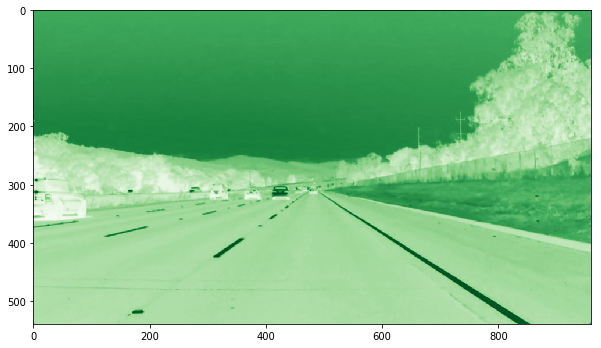

In [4]:
plt.figure(figsize=(10,7))
plt.imshow(image[:,:,1],cmap='Greens');

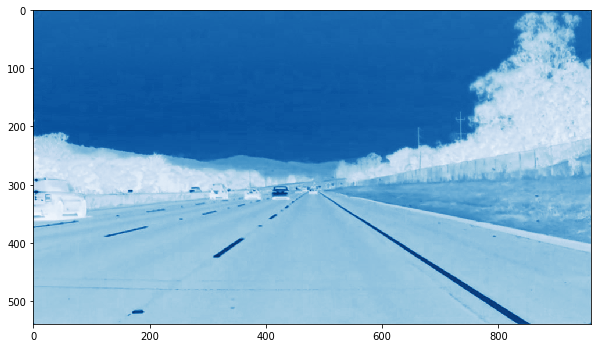

In [5]:
plt.figure(figsize=(10,7))
plt.imshow(image[:,:,2],cmap='Blues');

Looking at each channel does not immediately suggest a particular channel will be more useful for the task than any other.  In this case we should be able to use a single grayscale image in the pipeline.

## Helper Functions

In [6]:
import math

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# draws lines on an image in place
def draw_lines(img, lines, color=[0, 255, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap,horizontal_threshold=0.0):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    
    return line_img

## Test Images

Let's load some additional images in order to check our pipeline generalizes to a few other conditions (yellow lane lines, different road inclinations, etc).

In [7]:
import os
test_img_files = os.listdir("test_images/")

# Loading the test images into an array
test_images = []
test_imgs_root = 'test_images/'
for img in test_img_files:
    tmp = mpimg.imread(test_imgs_root+img)
    test_images.append(tmp)

ntest_imgs = len(test_images)
print('loaded: ',ntest_imgs,' test images')

loaded:  7  test images


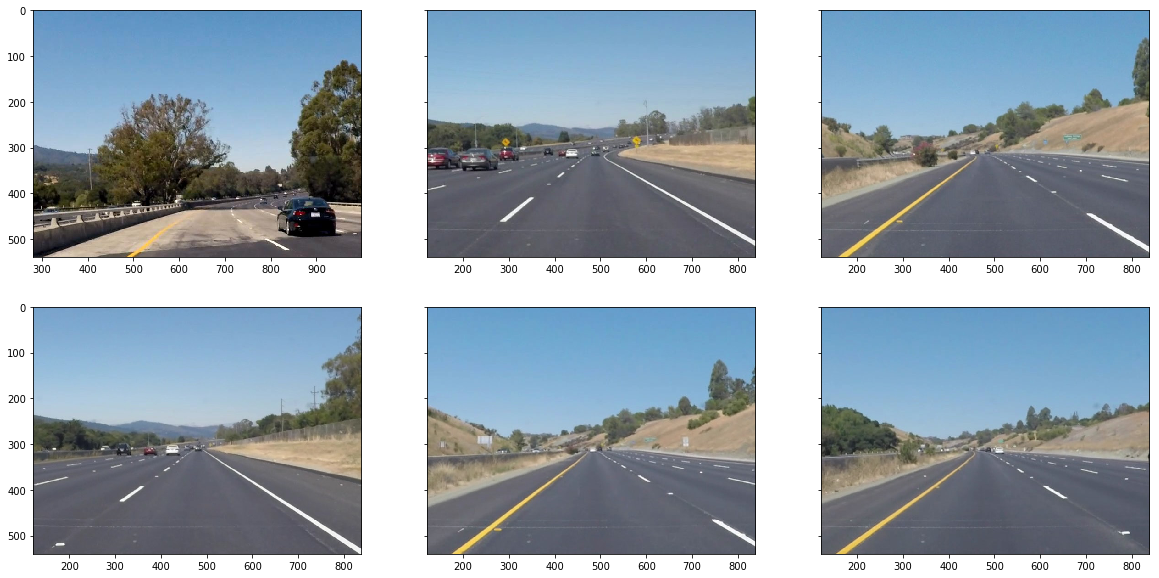

In [8]:
# Visualizing 6 test images -- the first is considered "challenging"
fig, axes = plt.subplots(2, 3, sharey=True,figsize=(20,10))
idx = 0;
for r in range(len(axes)):
    for c in range(len(axes[0])):
        axes[r][c].imshow(test_images[idx])
        idx += 1
plt.show();

## Building a Lane Finding Pipeline Step by Step

### Clean the Image Noise

If we apply the edge detection to a grayscale image we will likely find many non-useful edges due to sensor noise. In order to reduce the sensor noise such that only true edges remain in the image, a Gaussian smoothing kernel is convoluted over the image which results in image blurring at the scale of the Gaussian kernel size. I found setting to 9 pixels works well for this data set.

In [9]:
ydim,xdim,nch = image.shape

# conversion to grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# In order to remove some of the noise
# that can lead to spurious edge detection
# we want to use Gaussian noise reduction so
# the only remaining gradients are true to the image
# and not associated with sensor noise
gauss_kernel_width = 9;
if (gauss_kernel_width % 2)==0: #enforcing the odd number kernel size used in kernel smoothing
    gauss_kernel_width += 1
    
smooth_image= cv2.GaussianBlur(image_gray,(gauss_kernel_width,gauss_kernel_width),0)

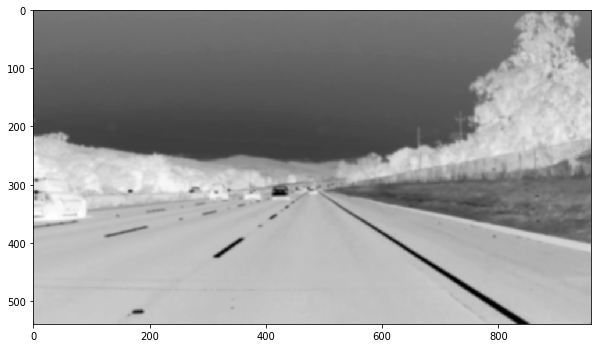

In [10]:
plt.figure(figsize=(10,7))
plt.imshow(smooth_image,cmap='Greys');

### Canny Gradient Thresholding

Next we want to apply Canny edge detection to find pixel gradients. OpenCV allows Canny thresholding such that we can set how sensitive we should be to the magnitude of gradients at each pixel in order to draw edges which are in the output. I found for this data set a minimum threshold of 100 (such that all gradients below this value are discarded) and a maximum threshold of 130 (such that all gradients above this threshold are kept) works well.

In [11]:
lower,upper = 100,130
image_edged = cv2.Canny(smooth_image,lower,upper)

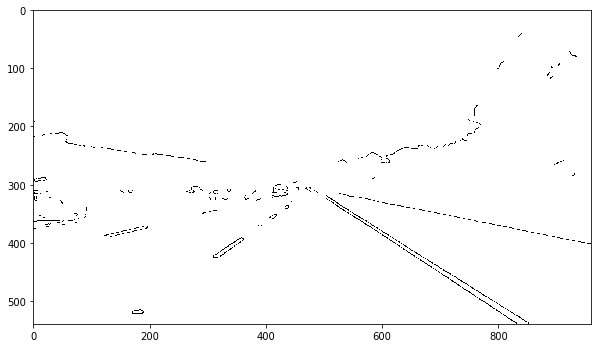

In [12]:
plt.figure(figsize=(10,7))
plt.imshow(image_edged,cmap='Greys');

Note in the above image that edges from car outlines are found by the edge detection which we don't want influencing our lane detection. It is also true that much of the image space is physically incompatible with containing lane edge information associated with the lane lines directly in front of the vehicle.  Thus in order to remove this noise we use a mask such that we select only portions of the image that are relevant to finding lanes directly in front of the vehicle.

### Setting a Region of Interest Mask

In [13]:
# this is a finally tuned polygon definition such that
# the area extremely close to the vehicle is discarded
# but along the expected horizon direction is kept
# it would be nice to have a way to detect the sky-land
# edge such that the true horizon could be incorprated
# in this bounding mask

lower,upper = 1,1#turning the threshold way down in order to display the bounding polygon
image_edged_poly = cv2.Canny(smooth_image,lower,upper)

bounding_poly_verts = np.array([[
                                (xdim*0.48,ydim*0.61), #upper left
                                (xdim*0.535,ydim*0.61), #upper right
                                (xdim*0.92,ydim), #lower right
                                (xdim*0.77,ydim), #front of car cutout polygon
                                (xdim*0.66,ydim*0.8),
                                (xdim*0.36,ydim*0.8),
                                (xdim*0.24,ydim), # end front of car cutout
                                (xdim*0.12,ydim) #lower left
                               ]],dtype='int32')

image_masked = region_of_interest(image_edged, bounding_poly_verts)
image_masked_poly = region_of_interest(image_edged_poly, bounding_poly_verts)

Note below I've purposely changed the edge detection threshold in order to highlight the shape of the bounding polygon

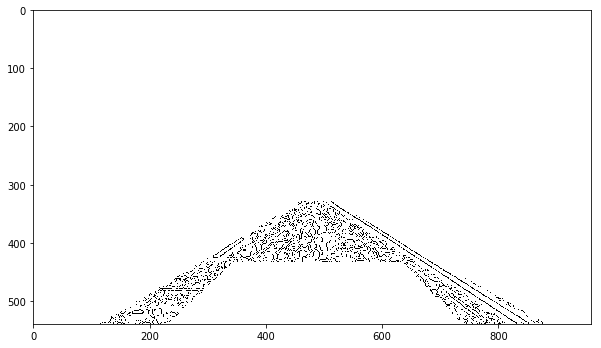

In [14]:
plt.figure(figsize=(10,7))
plt.imshow(image_masked_poly,cmap='Greys');

Now that we have the edges we want to apply a Hough transformation such that the output is a drawing of multiple points on the image that are detected to be associated with longish (I found a 7 pixel min line length threshold to work for this dataset) line segments.  This is like clustering points with line segments on the image.

### Drawing Hough Line Points

In [15]:
# Finding the Hough line points
lined_img = hough_lines(image_masked, 
                        rho=1.0, 
                        theta=1*np.pi/180., 
                        threshold=7, 
                        min_line_len=7, 
                        max_line_gap=10)

# combining the Hough line points with the original image
annotated_img = cv2.addWeighted(src1=lined_img,alpha=1.,src2=image,beta=1.0,gamma=0.0)

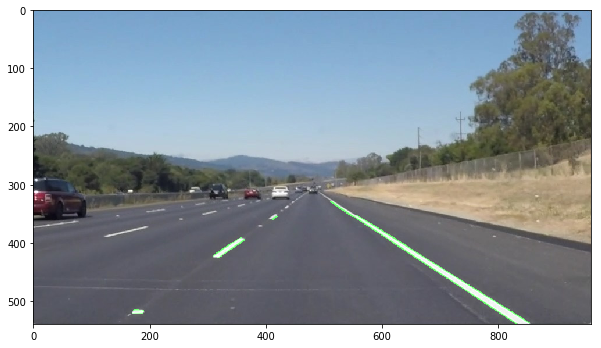

In [16]:
plt.figure(figsize=(10,7))
plt.imshow(annotated_img);

Now that we have the lane line points drawn on the image (in green above), we still need to draw single lines for the left and right lane line in the image. However we need to consider some other cases before deciding how to do that. Consider the image below.

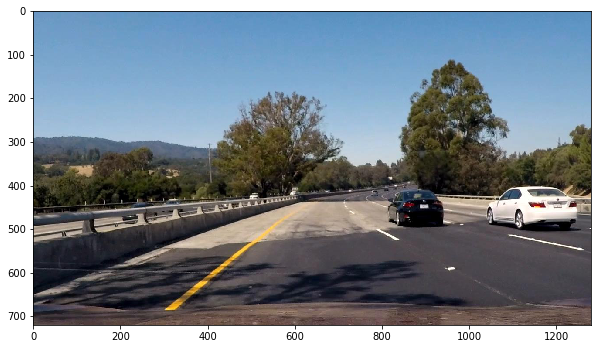

In [17]:
car_in_frame_img = mpimg.imread('test_images/car_in_frame.jpg')
plt.figure(figsize=(10,7))
plt.imshow(car_in_frame_img);

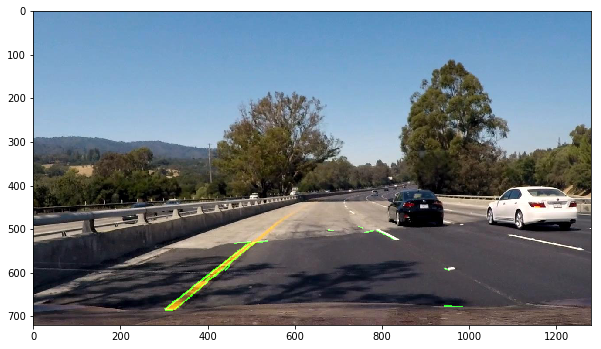

In [18]:
# apply our pipeline so far
image_gray = cv2.cvtColor(car_in_frame_img, cv2.COLOR_RGB2GRAY)
smooth_image= cv2.GaussianBlur(image_gray,(9,9),0)
image_edged = cv2.Canny(smooth_image,100,130)
ydim,xdim,nch = car_in_frame_img.shape
bounding_poly_verts = np.array([[
                                (xdim*0.48,ydim*0.61), #upper left
                                (xdim*0.535,ydim*0.61), #upper right
                                (xdim*0.92,ydim), #lower right
                                (xdim*0.77,ydim), #front of car cutout polygon
                                (xdim*0.66,ydim*0.8),
                                (xdim*0.36,ydim*0.8),
                                (xdim*0.24,ydim), # end front of car cutout
                                (xdim*0.12,ydim) #lower left
                               ]],dtype='int32')
image_masked = region_of_interest(image_edged, bounding_poly_verts)
lined_img = hough_lines(image_masked,rho=1.0,theta=np.pi/180.,threshold=7,min_line_len=7,max_line_gap=10)
annotated_img = cv2.addWeighted(src1=lined_img,alpha=1.,src2=car_in_frame_img,beta=1.0,gamma=0.0)

plt.figure(figsize=(10,7))
plt.imshow(annotated_img);

Notice how we have edges (again in green) which appear at the concrete-asphalt interface, which we don't want. We can improve our pipeline by removing lines whose slope is below some threshold ie too flat to be actual lane edges. I found the threshold for slope magnitudes below $0.37$ should be discarded. 

We don't see any edges at the concrete yellow interface in the image above!  This is due to the gray scale image not having enough contrast between the concrete and yellow line.  In order to find this edge we will apply edge detection to each color channel and combine the edges before Hough lines are drawn, as is done below.

In [19]:
# used to draw Hough lines with thresholding based 
# on the magintude of slope of the Hough line
def draw_lines_thresh(img, lines, color=[0, 255, 0], thickness=2, horizontal_threshold=0.0):    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # trying to filter any lines that are too horizontal like backs of cars
            # or road material iterfaces
            abs_m = abs((y2-y1)/(x2-x1))
            if abs_m > horizontal_threshold:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness) 

# modifed Hough lines function with slope thresholding option
def hough_lines_thresh(img, rho, theta, threshold, min_line_len, max_line_gap,horizontal_threshold=0.0):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines_thresh(line_img, lines, horizontal_threshold=horizontal_threshold)
    
    return line_img

In [20]:
ydim,xdim,nch = car_in_frame_img.shape

bounding_poly_verts = np.array([[
                                (xdim*0.48,ydim*0.61), #upper left
                                (xdim*0.535,ydim*0.61), #upper right
                                (xdim*0.92,ydim), #lower right
                                (xdim*0.77,ydim), #front of car cutout polygon
                                (xdim*0.66,ydim*0.8),
                                (xdim*0.36,ydim*0.8),
                                (xdim*0.24,ydim), # end front of car cutout
                                (xdim*0.12,ydim) #lower left
                               ]],dtype='int32')

image_combined = np.zeros_like(car_in_frame_img[:,:,0])

for ch in range(nch):
    image_smooth= cv2.GaussianBlur(car_in_frame_img[:,:,ch],(9,9),0)
    image_edged = cv2.Canny(image_smooth,100,130)
    image_masked = region_of_interest(image_edged, bounding_poly_verts)
    image_combined = cv2.addWeighted(src1=image_combined,alpha=1.,src2=image_masked,beta=1.0,gamma=0.0)

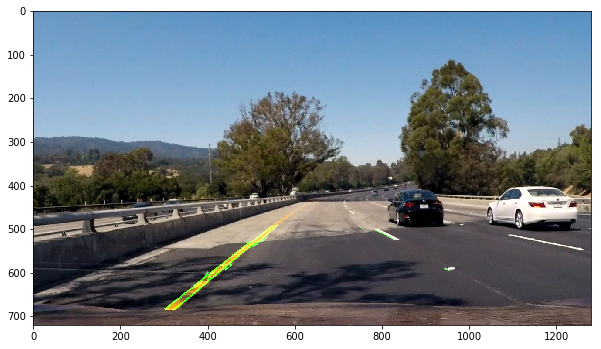

In [21]:
lined_img = hough_lines_thresh(image_combined,rho=1.0,theta=np.pi/180.,\
                               threshold=7,min_line_len=7,max_line_gap=10,\
                               horizontal_threshold=0.37)
annotated_img = cv2.addWeighted(src1=lined_img,alpha=1.,src2=car_in_frame_img,beta=1.0,gamma=0.0)

plt.figure(figsize=(10,7))
plt.imshow(annotated_img);

With thresholding and Canny edge detection per channel, we have line edges that represent the left and right lanes. However the edges of the lane markers are disconnected, how do we draw a single line for each lane? One possible method could involve using some Bayesian priors for what you would expect the line parameters to be and find the maximum a posterior parameters, but computing that may not be sufficiently fast for the task.

Instead we will fit a linear model to the Hough line points that make up the left and right lane edges and from those parameters draw line segments that extend from the bottom of the image to about $40/%$ image width as you move from the bottom up.  In addition to allowing us to draw single lane lines, this method also allows us to compute a residual variance of the Hough line points to the fitted line.  This variance allows us to represent the confidence in the pipelines ability to correctly find a singular lane for each lane line.

In [22]:
def draw_lines_fitted(img, lines, alpha=1.0, horizontal_threshold=0.0,\
                      color=[0,255,0], thickness=2):
    
    ydim,xdim,_ = img.shape
    # tuneable horizon distance to draw lane lines to 
    y_horizon = int(ydim*0.6)
    
    # containers to hold point data
    # from the Hough lines in order
    # to seperate the left from right
    # lane line data points
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #trying to filter any lines that are too horizontal like backs of cars
            m = (y2-y1)/(x2-x1)
            if abs(m) > horizontal_threshold:
                # if leaning right in the image
                if m < 0.0:
                    left_line_x.append(x1)
                    left_line_y.append(y1)
                    left_line_x.append(x2)
                    left_line_y.append(y2)
                # else it is leaning left
                else:
                    right_line_x.append(x1)
                    right_line_y.append(y1)
                    right_line_x.append(x2)
                    right_line_y.append(y2)
    
    # computing the best fit line parameters for the left and right lane markers
    m_left,b_left = np.polyfit(left_line_x, left_line_y, 1)
    m_right,b_right = np.polyfit(right_line_x, right_line_y, 1)
    
    # computing the end points to draw the
    # lane lines at in the image
    x_lowleft = int((ydim-b_left)/m_left)
    x_highleft = int((y_horizon-b_left)/m_left)
    x_lowright = int((ydim-b_right)/m_right)
    x_highright = int((y_horizon-b_right)/m_right)
    
    # overlay the lane lines on the image with increased thickness
    cv2.line(img, (x_lowleft, ydim), (x_highleft, y_horizon), color, thickness)
    cv2.line(img, (x_lowright, ydim), (x_highright, y_horizon), color, thickness)


# modifying hough_lines to allow the option of drawing the mean lines
def hough_lines_fitted(img, rho, theta, threshold, min_line_len, max_line_gap,\
                fit_lines=False,horizontal_threshold=0.0,color=[0,255,0]):
    # finds Hough lines in a probabilitic manner such that not all points
    # need to be considered in order to find edges that should be combined into
    # singluar lines.
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # option to just draw the Hough lines, or draw the best fit lines
    if fit_lines:
        draw_lines_fitted(line_img,lines,horizontal_threshold=horizontal_threshold,\
                          color=color,thickness=4)
    else:
        draw_lines_thresh(line_img,lines,horizontal_threshold=horizontal_threshold,\
                          color=color,thickness=2)
        
    return line_img

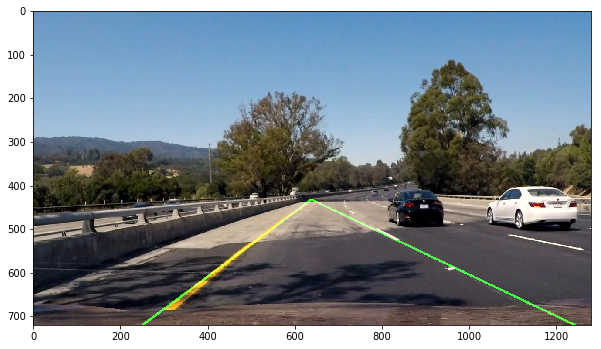

In [23]:
lined_img = hough_lines_fitted(image_masked,rho=1.0,theta=np.pi/180.,\
                               threshold=7,min_line_len=7,max_line_gap=10,\
                               horizontal_threshold=0.37,fit_lines=True)
annotated_img = cv2.addWeighted(src1=lined_img,alpha=1.,src2=car_in_frame_img,beta=1.0,gamma=0.0)

plt.figure(figsize=(10,7))
plt.imshow(annotated_img);

Looks okay, the lane lines are heavily weighted toward the lane marking closest to the camera, but lets roll all these pieces into a single function and look at its performance on all our test cases before considering further modifications for sequences of images.

In [24]:
def draw_lane_lines(img,gauss_kernel_width=9,canny_lower=100,canny_upper=130,\
                    horizontal_threshold=0.0,fit_lines=False,color=[0,255,0]):
    # image meta info
    ydim,xdim,nch = img.shape
        
    #enforcing the odd number kernel size
    if (gauss_kernel_width % 2)==0:
        gauss_kernel_width += 1
    
    # generating the cut out polygon
    bounding_poly_verts = np.array([[
                                (xdim*0.44,ydim*0.61), #upper left
                                (xdim*0.58,ydim*0.61), #upper right
                                (xdim*0.99,ydim), #lower right
                                (xdim*0.77,ydim), #front of car cutout polygon
                                (xdim*0.66,ydim*0.8),
                                (xdim*0.36,ydim*0.8),
                                (xdim*0.24,ydim), # end front of car cutout
                                (xdim*0.12,ydim) #lower left
                               ]],dtype='int32')
    
    # per channel apply the analysis
    img_combined = np.zeros_like(img[:,:,0])

    for ch in range(nch):
        # Gaussian smoothing
        img_smooth = cv2.GaussianBlur(img[:,:,ch],(gauss_kernel_width,gauss_kernel_width),0)
        # Canney edge detection
        img_edged = cv2.Canny(img_smooth,canny_lower,canny_upper)
        # region of interest masking
        img_masked = region_of_interest(img_edged, bounding_poly_verts)
        img_combined = cv2.addWeighted(src1=img_combined,alpha=1.,src2=img_masked,beta=1.0,gamma=0.0)

    # using hough lines to draw the best lane markers if the option
    # is selected otherwise use the threshold and just draw Hough lines
    lined_img = hough_lines_fitted(img_combined,
                            rho=1.0,
                            theta=np.pi/180.,
                            threshold=7,
                            min_line_len=7,
                            max_line_gap=10,
                            fit_lines=fit_lines,
                            horizontal_threshold=horizontal_threshold,
                            color=color)
    
    # overlay the Hough lines or best fit lane lines
    annotated_img = cv2.addWeighted(src1=lined_img,alpha=1.0,src2=img,beta=1.0,gamma=0.0)
    
    return annotated_img

Running the pipeline on some test cases

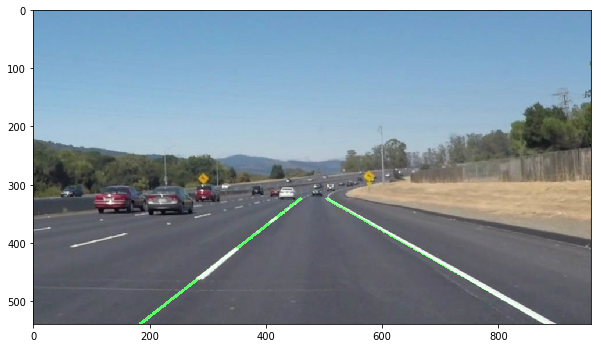

In [25]:
#test image 1
plt.figure(figsize=(10,7))
plt.imshow(draw_lane_lines(test_images[1],horizontal_threshold=0.37,fit_lines=True));

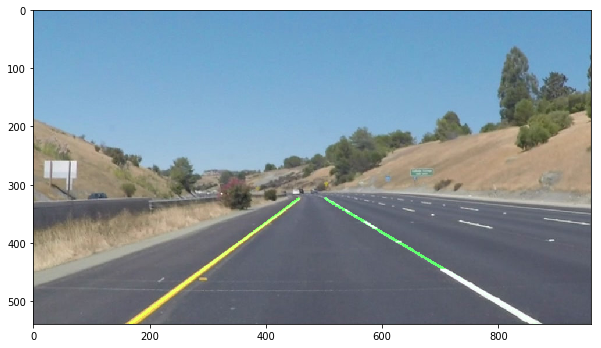

In [26]:
# test image 2
plt.figure(figsize=(10,7))
plt.imshow(draw_lane_lines(test_images[2],horizontal_threshold=0.37,fit_lines=True));

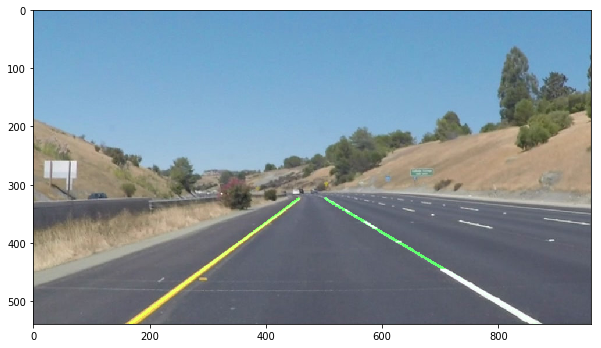

In [27]:
# test image 3
plt.figure(figsize=(10,7))
plt.imshow(draw_lane_lines(test_images[2],horizontal_threshold=0.37,fit_lines=True));

Looks pretty good. Lets move to videos.

## Application to Video

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Exponential Smoothing

We can naively apply the image processing pipeline built above, frame-by-frame and see the output, and that should work okay. However we want to take advantage of two key pieces of information, on a highway/high-speed we know that there shouldn't be any sharp turns present and therefore in terms of lane lines there shouldn't be any dramatic deviations frame-to-frame between the lane lines.  This allows us to use smoothing so that any major changes to the lane lines needs to be present over several frames and not some noise found in a single frame.  This is accomplished via exponential smoothing where the lane line endpoints are updated via:

$x'_{n} = \alpha x_{n} + (1-\alpha)x'_{n-1}$

where $x'_n$ are the end points for a single lane in the $n$-th frame, and $\alpha$ is a real number set between $0$ and $1$ such that the computed endpoints in frame $n$ given by $x_n$ influnce the final lane line endpoints $x'_n$ by $\alpha$ much.

### Lane Confidence Incorporation

Furthermore if for any one frame we find for ethier best fit lines, a high variance of residual errors, then we should not be confident that the method was able to find a good lane line.  In this case we should not let this frame's lane line endpoints have strong influence in the weighted average. We set a variance threshold if the residual variance is above the threshold we lower the weight of the current frame lane line end points from the selected single frame influence.  Thus low confidence frames will default to the previous frame's lane line rather than using the poor estimation of the lane line for the current frame. These pieces are implemented below.

In [29]:
# global variable used for exponential smoothing 
# the end points of the lane lines are stored here
# but must be initialized to None before each video 
prev_pts = [None]*4

def draw_lines_seq(img,lines,current_frame_weight=1.0,horizontal_threshold=0.0,\
                   variance_confidence=False,color=[0,255,0],thickness=2):
    
    ydim,xdim,_ = img.shape
    # tuneable horizon distance to draw lane lines to 
    y_horizon = int(ydim*0.6)
    
    # containers to hold point data
    # from the Hough lines in order
    # to seperate the left from right
    # lane line data points
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #trying to filter any lines that are too horizontal like backs of cars
            m = (y2-y1)/(x2-x1)
            if abs(m) > horizontal_threshold:
                # if leaning right in the image
                if m < 0.0:
                    left_line_x.append(x1)
                    left_line_y.append(y1)
                    left_line_x.append(x2)
                    left_line_y.append(y2)
                # else it is leaning left
                else:
                    right_line_x.append(x1)
                    right_line_y.append(y1)
                    right_line_x.append(x2)
                    right_line_y.append(y2)
    
    # its possible that no points will be found that 
    # satisfy the filter and in that case we could default to
    # some slope and intercept but I'd rather
    # have numpy throw the exception
    m_left,b_left = np.polyfit(left_line_x, left_line_y, 1)
    m_right,b_right = np.polyfit(right_line_x, right_line_y, 1)
    
    # if you choose to incorporate information
    # about how confident the best fit line
    # is we compute the variance of the residuals
    # of each best fit line
    if variance_confidence:
        left_line_x = np.array(left_line_x)
        right_line_x = np.array(right_line_x)
        left_line_y = np.array(left_line_y)
        right_line_y = np.array(right_line_y)
    
        left_fit = m_left*left_line_x+b_left
        right_fit = m_right*right_line_x+b_right
    
        var_left = np.mean((left_fit-left_line_y)**2)
        var_right = np.mean((right_fit-right_line_y)**2)
    
    # computing the end points to draw the
    # lane lines at in the image
    x_lowleft = int((ydim-b_left)/m_left)
    x_highleft = int((y_horizon-b_left)/m_left)
    x_lowright = int((ydim-b_right)/m_right)
    x_highright = int((y_horizon-b_right)/m_right)
    
    # if we are processing sequences of images we are
    # going to allow the use of exponential smoothing
    # so that a single image does not have undue influence
    # on the lane lines. This should make the pipeline more 
    # robust to transient noise (ethier on the road or from the sensor) 
    # in the images.
    alpha_right = current_frame_weight
    alpha_left = current_frame_weight
    
    
    # if theres too much variance in the residuals of the best fit lines
    # than we are not confident in the lane line and we shouldnt it 
    # let the current best fit line influence the drawing of the lane
    # too much. Furthermore the influence of a frame should be dependent 
    # on the variance of the residuals such that:
    # 1) high variance results in low influence in the drawing of the lane line
    # 2) low variance result in high influence in the drawing of the lane line
    if variance_confidence:
        # tuned parameters that seems to work for this data set 
        # not sure how well it generalizes...
        var_rate = 150.0
        var_threshold = 70.0
        
        # using exponential decay if the variance is high
        if var_right > var_threshold:
            alpha_right = alpha_right*np.exp(-(var_right-var_threshold)/var_rate)
        if var_left > var_threshold:
            alpha_left = alpha_left*np.exp(-(var_left-var_threshold)/var_rate)
    
    # using the previous end points with exponential smoothing
    # to draw the next lines.  Note that if alpha = 1.0 and 
    # variance checking is off, each frame draws it's best fit line,
    # without considering previous best fit lines.
    global prev_pts
    # always draw the best fit line for the first frame without influcence
    # from any parameters.
    if prev_pts[0] != None:
        x_lowleft = int(alpha_left*x_lowleft + (1.-alpha_left)*prev_pts[0])
        x_highleft = int(alpha_left*x_highleft + (1.-alpha_left)*prev_pts[1])
        x_lowright = int(alpha_right*x_lowright + (1.-alpha_right)*prev_pts[2])
        x_highright = int(alpha_right*x_highright + (1.-alpha_right)*prev_pts[3])
    
    # store the previous end points from the last drawn lane line frame
    prev_pts = [x_lowleft,x_highleft,x_lowright,x_highright]
    
    # overlay the lane lines on the image with increased thickness
    cv2.line(img, (x_lowleft, ydim), (x_highleft, y_horizon), color, thickness*3)
    cv2.line(img, (x_lowright, ydim), (x_highright, y_horizon), color, thickness*3)

In [30]:
def hough_lines_seq(img, rho, theta, threshold, min_line_len, max_line_gap,\
                    fit_lines=False,horizontal_threshold=0.0,\
                    current_frame_weight=1.0,variance_confidence=False):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    # option to just draw the Hough lines, or draw the best fit lines
    if fit_lines:
        draw_lines_seq(line_img,lines,horizontal_threshold=horizontal_threshold,\
                       current_frame_weight=current_frame_weight,variance_confidence=variance_confidence,\
                       color=[0,255,0],thickness=4)
    else:
        draw_lines_thresh(line_img,lines,horizontal_threshold=horizontal_threshold,\
                          color=[0,255,0],thickness=2)
        
    return line_img

In [31]:
def draw_lane_lines_seq(img,gauss_kernel_width=9,canny_lower=100,canny_upper=130,\
                        horizontal_threshold=0.0,fit_lines=False,current_frame_weight=1.0,\
                        variance_confidence=False):
    # image meta info
    ydim,xdim,nch = img.shape
        
    #enforcing the odd number kernel size
    if (gauss_kernel_width % 2)==0:
        gauss_kernel_width += 1
    
    # generating the cut out polygon
    bounding_poly_verts = np.array([[
                                (xdim*0.44,ydim*0.61), #upper left
                                (xdim*0.58,ydim*0.61), #upper right
                                (xdim*0.99,ydim), #lower right
                                (xdim*0.77,ydim), #front of car cutout polygon
                                (xdim*0.66,ydim*0.8),
                                (xdim*0.36,ydim*0.8),
                                (xdim*0.24,ydim), # end front of car cutout
                                (xdim*0.12,ydim) #lower left
                               ]],dtype='int32')
    
    # per channel apply the analysis
    img_combined = np.zeros_like(img[:,:,0])

    for ch in range(nch):
        # Gaussian smoothing
        img_smooth = cv2.GaussianBlur(img[:,:,ch],(gauss_kernel_width,gauss_kernel_width),0)
        # Canney edge detection
        img_edged = cv2.Canny(img_smooth,canny_lower,canny_upper)
        # region of interest masking
        img_masked = region_of_interest(img_edged, bounding_poly_verts)
        img_combined = cv2.addWeighted(src1=img_combined,alpha=1.,src2=img_masked,beta=1.0,gamma=0.0)
    
    # draw lane lines taking the influence of previous frames into account
    lined_img = hough_lines_seq(
                            img_combined,
                            rho=1.0,
                            theta=np.pi/180.,
                            threshold=7,
                            min_line_len=7,
                            max_line_gap=10,
                            fit_lines=fit_lines,
                            horizontal_threshold=horizontal_threshold,
                            current_frame_weight=current_frame_weight,
                            variance_confidence=variance_confidence)
    
    # overlay the Hough lines or best fit lane lines
    annotated_img = cv2.addWeighted(src1=lined_img,alpha=1.0,src2=img,beta=1.0,gamma=0.0)
    
    return annotated_img

In [32]:
def process_image(image):
    return draw_lane_lines_seq(image,
                               horizontal_threshold=0.37,
                               canny_lower=100,
                               canny_upper=130,
                               fit_lines=True,
                               current_frame_weight=0.25, #only let the current frame have a weight of 0.25
                               variance_confidence=True)

Applying the pipeline to video

In [33]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

# initialize the previous end points buffer
prev_pts = [None]*4

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:17<00:00, 12.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.51 s, sys: 233 ms, total: 5.75 s
Wall time: 18.9 s


link to the annotated video [solidWhiteRight.mp4](test_videos_output/solidWhiteRight.mp4)

This one's more tricky as it includes yellow and white in the lane markings.

In [35]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

prev_pts = [None]*4
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:56<00:00, 12.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 16.9 s, sys: 745 ms, total: 17.6 s
Wall time: 58.2 s


link to annotated video [solidYellowLeft.mp4](test_videos_output/solidYellowLeft.mp4)

Looks good.


### The Challenging Video

This next video is the most challenging for this method as it contains many false/non-lane edges in the region of interest as well as different lighting conditions, and transitions from asphalt to concrete and back again when crossing a short bridge, lets see how it performs before making modifcations. 

I encourage the user to change the current frame weight values and see how performance changes as well as inclusion/exclusion of variance confidence.  In this video I set the current frame weight to 1.0 to explore how it performs without incorporating any sequence data.

In [37]:
def process_image(image):
    return draw_lane_lines_seq(image,
                               horizontal_threshold=0.37,
                               canny_lower=100,
                               canny_upper=130,
                               fit_lines=True,
                               current_frame_weight=1.0,#compute each image without considering the seq
                               variance_confidence=False)

In [38]:
challenge_output1 = 'test_videos_output/challenge_1.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')

prev_pts = [None]*4
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output1, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_1.mp4
[MoviePy] Writing video test_videos_output/challenge_1.mp4


100%|██████████| 251/251 [00:42<00:00,  6.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_1.mp4 

CPU times: user 11.1 s, sys: 1.4 s, total: 12.5 s
Wall time: 45.9 s


link to annotated video [solidYellowLeft.mp4](test_videos_output/challenge_1.mp4)

Notice how noisy the lines are! Let's look at some of the individual frames to understand why.

In [40]:
# Finding and debugging troublesome frames
frames_clip3 = []
for frame in clip3.iter_frames():
    frames_clip3.append(frame)

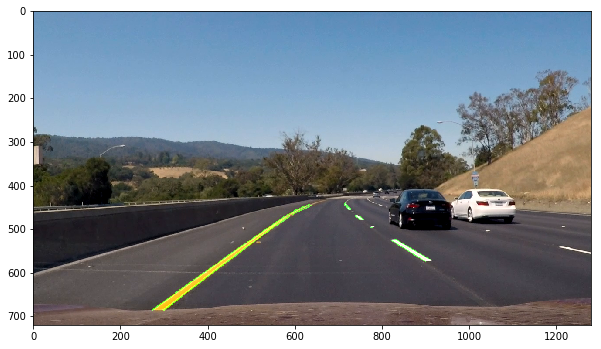

In [41]:
plt.figure(figsize=(10,7))
plt.imshow(draw_lane_lines(frames_clip3[20],
                           canny_lower=130,
                           canny_upper=130,
                           horizontal_threshold=0.37,
                           fit_lines=False,
                           color=[0,255,0]));

In this frame the Hough lines are mostly pointed to the right! Even the right lane markers! Our assumption that the right lane edges always have a slope pointed toward the center from the right side is violated.  

In order to combat this we will require any lines which have a slope associated with a left lane must also be found on the left side of the image, and vice versa for the right lane.  This isn't ideal as we should take the turning angle into account but we don't have that information, lets see the effect of this new filter.

In [42]:
def draw_lines_fitted(img, lines, alpha=1.0, horizontal_threshold=0.0,\
                      color=[0,255,0], thickness=2):
    
    ydim,xdim,_ = img.shape
    # tuneable horizon distance to draw lane lines to 
    y_horizon = int(ydim*0.6)
    xmid = 0.5*xdim
    
    # containers to hold point data
    # from the Hough lines in order
    # to seperate the left from right
    # lane line data points
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #trying to filter any lines that are too horizontal like backs of cars
            m = (y2-y1)/(x2-x1)
            if abs(m) > horizontal_threshold:
                # if leaning right in the image
                if m < 0.0 and x1 <= xmid and x2 <= xmid:
                    left_line_x.append(x1)
                    left_line_y.append(y1)
                    left_line_x.append(x2)
                    left_line_y.append(y2)
                # else it is leaning left
                elif x1 >= xmid and x2 >= xmid:
                    right_line_x.append(x1)
                    right_line_y.append(y1)
                    right_line_x.append(x2)
                    right_line_y.append(y2)
    
    # computing the best fit line parameters for the left and right lane markers
    m_left,b_left = np.polyfit(left_line_x, left_line_y, 1)
    m_right,b_right = np.polyfit(right_line_x, right_line_y, 1)
    
    # computing the end points to draw the
    # lane lines at in the image
    x_lowleft = int((ydim-b_left)/m_left)
    x_highleft = int((y_horizon-b_left)/m_left)
    x_lowright = int((ydim-b_right)/m_right)
    x_highright = int((y_horizon-b_right)/m_right)
    
    # overlay the lane lines on the image with increased thickness
    cv2.line(img, (x_lowleft, ydim), (x_highleft, y_horizon), color, thickness)
    cv2.line(img, (x_lowright, ydim), (x_highright, y_horizon), color, thickness)

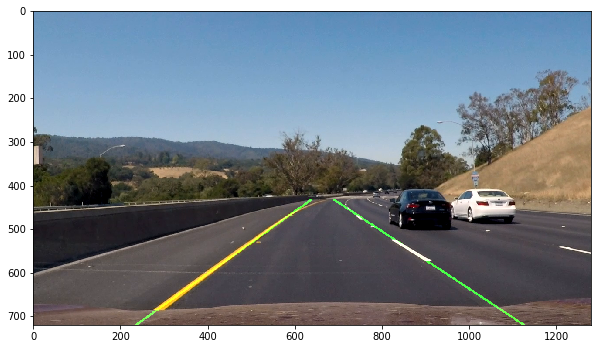

In [43]:
plt.figure(figsize=(10,7))
plt.imshow(draw_lane_lines(frames_clip3[20],
                           canny_lower=130,
                           canny_upper=130,
                           horizontal_threshold=0.37,
                           fit_lines=True,
                           color=[0,255,0]));

Looks good, lets apply this to the sequence of images.

In [44]:
# global variable used for exponential smoothing 
# the end points of the lane lines are stored here
# but must be initialized to None before each video 
prev_pts = [None]*4

def draw_lines_seq(img,lines,current_frame_weight=1.0,horizontal_threshold=0.0,\
                   variance_confidence=False,color=[0,255,0],thickness=2):
    
    ydim,xdim,_ = img.shape
    # tuneable horizon distance to draw lane lines to 
    y_horizon = int(ydim*0.6)
    xmid = 0.5*xdim
    
    # containers to hold point data
    # from the Hough lines in order
    # to seperate the left from right
    # lane line data points
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #trying to filter any lines that are too horizontal like backs of cars
            m = (y2-y1)/(x2-x1)
            if abs(m) > horizontal_threshold:
                # if leaning right in the image
                if m < 0.0 and x1 <= xmid and x2 <= xmid:
                    left_line_x.append(x1)
                    left_line_y.append(y1)
                    left_line_x.append(x2)
                    left_line_y.append(y2)
                # else it is leaning left
                elif x1 >= xmid and x2 >= xmid:
                    right_line_x.append(x1)
                    right_line_y.append(y1)
                    right_line_x.append(x2)
                    right_line_y.append(y2)
    
    # computing the best fit line parameters for the left and right lane markers
    if len(left_line_x) == 0:
        m_left,b_left = -0.7,(ydim+0.7*(0.12*xdim))
    else:
        m_left,b_left = np.polyfit(left_line_x, left_line_y, 1)
    
    if len(right_line_x) == 0:
        m_right,b_right = 0.7,(ydim-0.7*(0.99*xdim))
    else:
        m_right,b_right = np.polyfit(right_line_x, right_line_y, 1)
    
    # if you choose to incorporate information
    # about how confident the best fit line
    # is we compute the variance of the residuals
    # of each best fit line
    if variance_confidence:
        left_line_x = np.array(left_line_x)
        right_line_x = np.array(right_line_x)
        left_line_y = np.array(left_line_y)
        right_line_y = np.array(right_line_y)
    
        left_fit = m_left*left_line_x+b_left
        right_fit = m_right*right_line_x+b_right
    
        var_left = np.mean((left_fit-left_line_y)**2)
        var_right = np.mean((right_fit-right_line_y)**2)
    
    # computing the end points to draw the
    # lane lines at in the image
    x_lowleft = int((ydim-b_left)/m_left)
    x_highleft = int((y_horizon-b_left)/m_left)
    x_lowright = int((ydim-b_right)/m_right)
    x_highright = int((y_horizon-b_right)/m_right)
    
    # if we are processing sequences of images we are
    # going to allow the use of exponential smoothing
    # so that a single image does not have undue influence
    # on the lane lines. This should make the pipeline more 
    # robust to transient noise (ethier on the road or from the sensor) 
    # in the images.
    alpha_right = current_frame_weight
    alpha_left = current_frame_weight
    
    
    # if theres too much variance in the residuals of the best fit lines
    # than we are not confident in the lane line and we shouldnt it 
    # let the current best fit line influence the drawing of the lane
    # too much. Furthermore the influence of a frame should be dependent 
    # on the variance of the residuals such that:
    # 1) high variance results in low influence in the drawing of the lane line
    # 2) low variance result in high influence in the drawing of the lane line
    if variance_confidence:
        # tuned parameters that seems to work for this data set 
        # not sure how well it generalizes...
        var_rate = 150.0
        var_threshold = 70.0
        
        # using exponential decay if the variance is high
        if var_right > var_threshold:
            alpha_right = alpha_right*np.exp(-(var_right-var_threshold)/var_rate)
        if var_left > var_threshold:
            alpha_left = alpha_left*np.exp(-(var_left-var_threshold)/var_rate)
    
    # using the previous end points with exponential smoothing
    # to draw the next lines.  Note that if alpha = 1.0 and 
    # variance checking is off, each frame draws it's best fit line,
    # without considering previous best fit lines.
    global prev_pts
    # always draw the best fit line for the first frame without influcence
    # from any parameters.
    if prev_pts[0] != None:
        x_lowleft = int(alpha_left*x_lowleft + (1.-alpha_left)*prev_pts[0])
        x_highleft = int(alpha_left*x_highleft + (1.-alpha_left)*prev_pts[1])
        x_lowright = int(alpha_right*x_lowright + (1.-alpha_right)*prev_pts[2])
        x_highright = int(alpha_right*x_highright + (1.-alpha_right)*prev_pts[3])
    
    # store the previous end points from the last drawn lane line frame
    prev_pts = [x_lowleft,x_highleft,x_lowright,x_highright]
    
    # overlay the lane lines on the image with increased thickness
    cv2.line(img, (x_lowleft, ydim), (x_highleft, y_horizon), color, thickness*3)
    cv2.line(img, (x_lowright, ydim), (x_highright, y_horizon), color, thickness*3)

In [45]:
challenge_output2 = 'test_videos_output/challenge_2.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')

prev_pts = [None]*4
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output2, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_2.mp4
[MoviePy] Writing video test_videos_output/challenge_2.mp4


100%|██████████| 251/251 [00:41<00:00,  6.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_2.mp4 

CPU times: user 11.2 s, sys: 1.17 s, total: 12.4 s
Wall time: 44.8 s


link to annotated video [challenge_2.mp4](test_videos_output/challenge_2.mp4)

Better but still noisy. Let's turn on our noise smoothing features and see how it does.

In [47]:
def process_image(image):
    return draw_lane_lines_seq(image,
                               horizontal_threshold=0.37,
                               canny_lower=100,
                               canny_upper=130,
                               fit_lines=True,
                               current_frame_weight=0.25,
                               variance_confidence=True)

In [48]:
challenge_output3 = 'test_videos_output/challenge_3.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')

prev_pts = [None]*4
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output3, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_3.mp4
[MoviePy] Writing video test_videos_output/challenge_3.mp4


100%|██████████| 251/251 [00:41<00:00,  6.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_3.mp4 

CPU times: user 11.4 s, sys: 1.45 s, total: 12.8 s
Wall time: 45.5 s


link to annotated video [challenge_3.mp4](test_videos_output/challenge_3.mp4)

Much smoother now.  The deviation we see at about 4 seconds into the video is due to a black mark on the concrete on the right half of the image near the bottom. The black mark just so happens to have the right slope to be used in the calculation and pulls the best fit line toward the left. At this point I think is about as far as this simple methods can take us, and we'll move on to explore more advanced methods! Hope you enjoyed!